In [10]:
####################################################################################################
# TF.SNOTEL.dataExploration
# Karl Lapo February/2016
####################################################################################################
# SWE Trends  
####################################################################################################

# must insert this statement to render the plots within the notebook
# this is specific to the ipython notebook
%matplotlib inline

## Import statements
# netcdf/numpy/xray
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xray
import kray
import scipy.io as sio

# OS interaction
import sys, pickle, os

# import subplots function for plotting
import seaborn as sns
sns.set_context('talk')
sns.set_style('whitegrid')
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import kgraph
import matplotlib.gridspec as gridspec

#### Directory Lists
# Unix
if 'linux' in sys.platform:
    dir_pre = '/home/lapok/gdrive/'
# Mac
elif 'darwin' in sys.platform:
    dir_pre = '/Users/karllapo/gdrive/'

# Directory for the SNOTEL data
dir_data = dir_pre+'SnowHydrology/proj/TurbulenceFeedbacks/data/'

## Read LWdwn estimates from Mark
- 400 combinations of 20 clear-sky and 20 cloudy methods. 
- Highlight the best methods as identified by Flerchinger et al., 2009

In [11]:
# Read netcdf versions of Mark's data
os.chdir(dir_data)
LW = xray.open_dataset('LW_ensemble_SASP.nc')

y = 2005
npDatetime = [datetime(year=y,month=m,day=d,hour=h) if m < 10 else datetime(year=y-1,month=m,day=d,hour=h)\
              for m,d,h in zip(LW.MONTH,LW.DAY,LW.HOUR)]  
LW.coords['time'] = (('ntime'), npDatetime)
LW = LW.swap_dims({'ntime':'time'})

print(LW)

<xray.Dataset>
Dimensions:              (nflerch: 9, nmethod: 400, nsta: 400, time: 8760)
Coordinates:
  * nflerch              (nflerch) int64 0 1 2 3 4 5 6 7 8
  * nmethod              (nmethod) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...
  * nsta                 (nsta) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 ...
    ntime                (time) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 ...
  * time                 (time) datetime64[ns] 2004-10-01 ...
Data variables:
    MONTH                (time) int8 10 10 10 10 10 10 10 10 10 10 10 10 10 ...
    DAY                  (time) int8 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...
    HOUR                 (time) int8 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 ...
    LWmod                (nsta, time) float64 262.2 258.1 256.2 255.4 256.1 ...
    LWobs                (time) float64 222.8 227.4 218.4 228.5 231.7 231.7 ...
    FLERCHINGER_BEST     (nflerch) int32 1 7 8 9 241 247 248 249 189
    LW_method_clear_sky  (nmethod) int32 1 1 1 1 1 

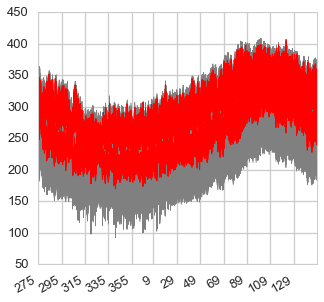

In [12]:
## All methods, highlighting the best
# Composited over 15 years @ SASP (by hour?)
fig,ax = plt.subplots(1,1,figsize=(5,5))
for method in LW.nsta:
    ax.plot(LW.time,LW.LWmod.values[method.nsta.values,:],color='grey',lw=.5)
    
for method in LW.nsta:
    method = method.nsta.values
    if (LW.FLERCHINGER_BEST == method).any():
        ax.plot(LW.time,LW.LWmod.values[method,:],color='r',lw=1)

ax.set_xticklabels(LW['time.dayofyear'].values[0::24*20]);
fig.autofmt_xdate()

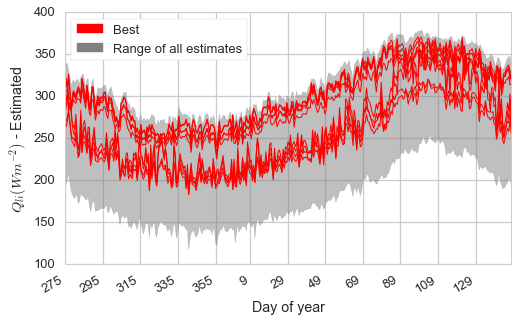

In [13]:
## Range of estimated LWdwn values (all methods)
## daily average day-of-year composites of the best methods from Flerchinger et al., 2009
fig,ax = plt.subplots(1,1,figsize=(8,5))

# Plot daily averages of the best methods
for method in LW.nsta:
    method = method.nsta.values
    if (LW.FLERCHINGER_BEST == method).any():
        ax.plot(LW.resample(how='mean',freq='d',dim='time').time,\
                LW.sel(nsta=method).resample(how='mean',freq='d',dim='time').LWmod,\
                lw=1,label=(str(method)),color='r')

# Shade the region spanned by all LW methods
LWmin = LW.resample(how='mean',freq='d',dim='time').LWmod.min(dim='nsta')
LWmax = LW.resample(how='mean',freq='d',dim='time').LWmod.max(dim='nsta')
plt.fill_between(LW.resample(how='mean',freq='d',dim='time').time.values,LWmin.values,LWmax.values,\
                alpha=.5,color='grey')
        
ax.set_xticklabels(LW['time.dayofyear'].values[0::24*20]);
ax.set_ylabel('$Q_{li} (Wm^{-2})$ - Estimated')
ax.set_xlabel('Day of year')
fig.autofmt_xdate()

## Legend
import matplotlib.patches as mpatches
patchRest = mpatches.Patch(color='grey',label='Range of all estimates')
patchBest = mpatches.Patch(color='r',label='Best')
ax.legend(handles=[patchBest,patchRest],loc='best',frameon=True)